## Dataset-Vergleich: Green vs Yellow vs FHV (Arbeitspaket 3) ##

Disclaimer: Daten aus anderen Notebooks wurden als Basis für den Vergleich genommen. Alle herbeigezogenen Daten können in den jeweiligen Notebooks gefunden oder erneut erstellt werden.

## Konfiguration ##

In [11]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns

# sorgt dafür, dass Plots im Notebook angezeigt werden
%matplotlib inline

# Lesbarkeit in der Exploration erhöhen
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 140)

In [12]:
# Projekt- und Dataset-Konfiguration
PROJECT_ID = "taxi-bi-project"
DATASET_ID = "staging"
BQ_LOCATION = "EU"
TABLE_FHV = "fhv_unified"       
TABLE_GREEN = "green_unified"
TABLE_YELLOW = "yellow_unified"

# Vollständiges Dataset-Prefix
FULL_DATASET_PREFIX = f"{PROJECT_ID}.{DATASET_ID}"

# BigQuery Client initialisieren
bq_client = bigquery.Client(project=PROJECT_ID, location=BQ_LOCATION)

/Users/vincentgoldmann/Documents/GitHub/bi_project_task1/.venv/lib/python3.13/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


## Allgemeiner Vergleich ##

In [6]:
# Unsere drei zentralen Views in BigQuery
VIEWS = {
    "YELLOW": {
        "table": "yellow_staging_unified",
    },
    "GREEN": {
        "table": "green_staging_unified",
    },
    "FHV": {
        "table": "fhv_staging_unified",
    },
}

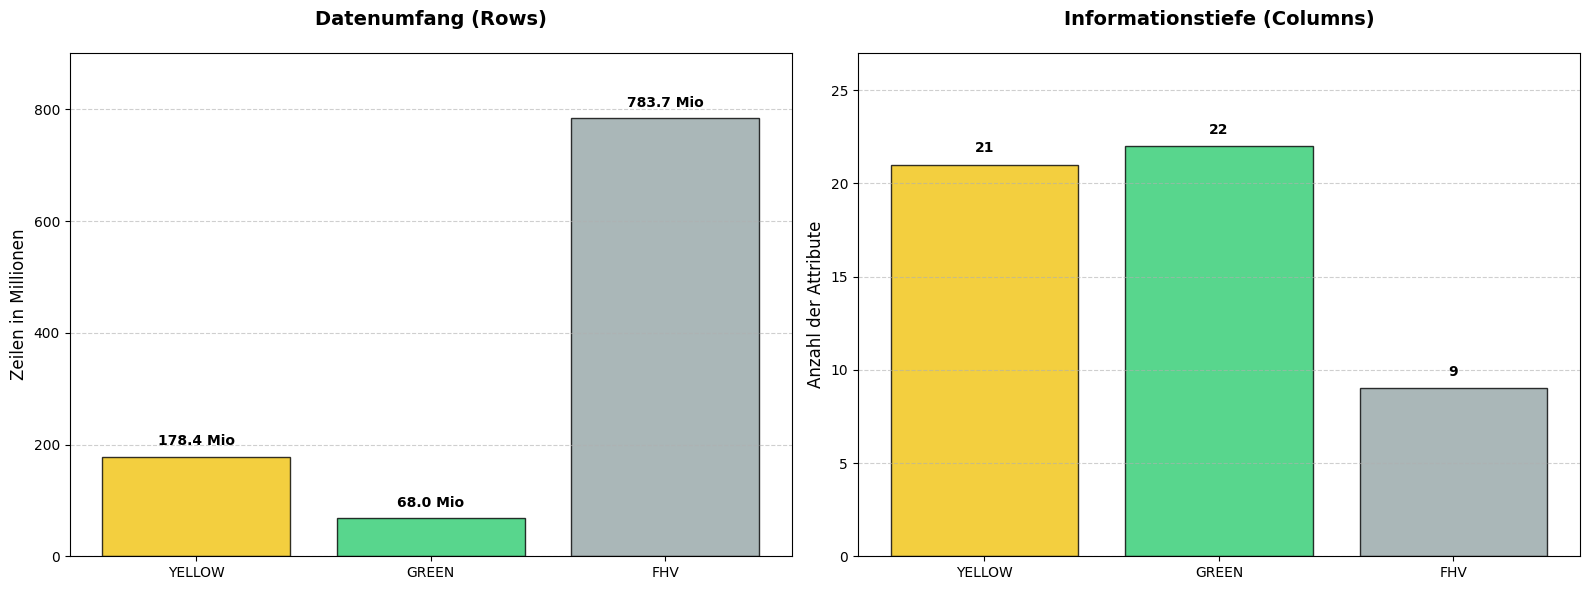

In [10]:
# 1. Metadaten über VIEWS-Dictionary abrufen
metadata_list = []

for alias, cfg in VIEWS.items():
    # Tabellenreferenz über den vollqualifizierten Pfad holen
    table_id = f"{FULL_DATASET_PREFIX}.{cfg['table']}"
    table_ref = bq_client.get_table(table_id)
    
    metadata_list.append({
        'View': alias,
        'Rows': table_ref.num_rows,
        'Columns': len(table_ref.schema)
    })

# 2. In DataFrame umwandeln
df_meta = pd.DataFrame(metadata_list)

# 3. Diagramm erstellen
colors = ['#f1c40f', '#2ecc71', '#95a5a6']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Datenumfang (in Millionen) ---
bars1 = ax1.bar(df_meta['View'], df_meta['Rows'] / 1_000_000, color=colors, edgecolor='black', alpha=0.8)
ax1.set_title('Datenumfang (Rows)', fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('Zeilen in Millionen', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Dynamische Labels mit Puffer nach oben
max_rows = df_meta['Rows'].max() / 1_000_000
ax1.set_ylim(0, max_rows * 1.15) 

for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + (max_rows * 0.02), f'{yval:.1f} Mio', ha='center', va='bottom', fontweight='bold')

# --- Plot 2: Informationstiefe (Spalten) ---
bars2 = ax2.bar(df_meta['View'], df_meta['Columns'], color=colors, edgecolor='black', alpha=0.8)
ax2.set_title('Informationstiefe (Columns)', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylabel('Anzahl der Attribute', fontsize=12)
ax2.set_ylim(0, df_meta['Columns'].max() + 5)
ax2.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Datenumfang (Rows): Mit ~784 Mio. Zeilen ist das FHV-Dataset das volumenstärkste, gefolgt von Yellow Taxi (~178 Mio.) und Green Taxi (~68 Mio.).

Informationstiefe (Columns): Die Taxi-Datensätze (Yellow/Green) bieten mit 21–22 Attributen eine deutlich höhere Granularität als der FHV-Datensatz, der lediglich 9 Attribute umfasst.

BI-Bewertung: Während FHV eine hohe statistische Signifikanz für Volumenanalysen liefert, ermöglichen ausschließlich die Taxi-Daten detaillierte finanzielle Segmentierungen (z. B. nach Gebührenstrukturen oder Zahlungstypen).

In [22]:
# Client initialisieren
bq_client = bigquery.Client(project=PROJECT_ID)

# --- FUNKTION ZUM LADEN ---
def load_random_sample(table_name: str, sample_size: int = 50_000) -> pd.DataFrame:
    """
    Lädt n zufällige Zeilen aus einer BigQuery Tabelle direkt in einen DataFrame.
    """
    print(f"⏳ Lade {sample_size} zufällige Zeilen aus {table_name}...")
    
    query = f"""
    SELECT *
    FROM `{PROJECT_ID}.{DATASET_ID}.{table_name}`
    ORDER BY RAND()
    LIMIT {sample_size}
    """
    
    return bq_client.query(query).to_dataframe()

# --- DATEN LADEN ---
fhv_df = load_random_sample(TABLE_FHV)
green_df = load_random_sample(TABLE_GREEN)
yellow_df = load_random_sample(TABLE_YELLOW)

print("Alle Daten geladen!\n")

# --- ANALYSE ---

# Display basic info to understand structure
print("--- FHV INFO ---")
print(fhv_df.info())
print("\n--- GREEN INFO ---")
print(green_df.info())
print("\n--- YELLOW INFO ---")
print(yellow_df.info())

# Display first few rows to see content
print("\n--- FHV HEAD ---")
print(fhv_df.head())
print("\n--- GREEN HEAD ---")
print(green_df.head())
print("\n--- YELLOW HEAD ---")
print(yellow_df.head())

/Users/vincentgoldmann/Documents/GitHub/bi_project_task1/.venv/lib/python3.13/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


⏳ Lade 50000 zufällige Zeilen aus fhv_unified...


/Users/vincentgoldmann/Documents/GitHub/bi_project_task1/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


⏳ Lade 50000 zufällige Zeilen aus green_unified...
⏳ Lade 50000 zufällige Zeilen aus yellow_unified...
✅ Alle Daten geladen!

--- FHV INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   dispatching_base_num    50000 non-null  object        
 1   pickup_datetime         50000 non-null  datetime64[us]
 2   dropOff_datetime        50000 non-null  datetime64[us]
 3   PUlocationID            37018 non-null  Int64         
 4   DOlocationID            30042 non-null  Int64         
 5   SR_Flag                 5610 non-null   object        
 6   Affiliated_base_number  49816 non-null  object        
 7   duplicate_flag          50000 non-null  object        
 8   missing_flag            50000 non-null  object        
dtypes: Int64(2), datetime64[us](2), object(5)
memory usage: 3.5+ MB
None

--- GREEN INFO

In [25]:
# Date conversion and Duration calculation
# FHV
fhv_df['pickup_datetime'] = pd.to_datetime(fhv_df['pickup_datetime'], errors='coerce')
fhv_df['dropOff_datetime'] = pd.to_datetime(fhv_df['dropOff_datetime'], errors='coerce')
fhv_df['duration_minutes'] = (fhv_df['dropOff_datetime'] - fhv_df['pickup_datetime']).dt.total_seconds() / 60

# Green
green_df['pickup_datetime'] = pd.to_datetime(green_df['lpep_pickup_datetime'], errors='coerce')
green_df['dropOff_datetime'] = pd.to_datetime(green_df['lpep_dropoff_datetime'], errors='coerce')
green_df['duration_minutes'] = (green_df['dropOff_datetime'] - green_df['pickup_datetime']).dt.total_seconds() / 60

# Yellow
yellow_df['pickup_datetime'] = pd.to_datetime(yellow_df['tpep_pickup_datetime'], errors='coerce')
yellow_df['dropOff_datetime'] = pd.to_datetime(yellow_df['tpep_dropoff_datetime'], errors='coerce')
yellow_df['duration_minutes'] = (yellow_df['dropOff_datetime'] - yellow_df['pickup_datetime']).dt.total_seconds() / 60

# Descriptive Statistics for Comparison
stats_summary = []

datasets = [('FHV', fhv_df), ('Green', green_df), ('Yellow', yellow_df)]

for name, df in datasets:
    # Duration Stats
    dur_desc = df['duration_minutes'].describe()
    
    # Distance Stats (if available)
    if 'trip_distance' in df.columns:
        dist_desc = df['trip_distance'].describe()
    else:
        dist_desc = pd.Series([np.nan]*8, index=dur_desc.index)
        
    # Price Stats 
    if 'total_amount' in df.columns:
        price_desc = df['total_amount'].describe()
    else:
        price_desc = pd.Series([np.nan]*8, index=dur_desc.index)

    # Missing values count (Top 3 columns with most missing)
    missing = df.isnull().sum().sort_values(ascending=False)
    missing_top3 = missing.head(3)
    
    stats_summary.append({
        'Dataset': name,
        'Duration_Mean': dur_desc['mean'],
        'Duration_Median': dur_desc['50%'],
        'Duration_Max': dur_desc['max'],
        'Duration_Min': dur_desc['min'],
        'Duration_Std': dur_desc['std'],
        'Distance_Mean': dist_desc['mean'],
        'Distance_Max': dist_desc['max'],
        'Price_Mean': price_desc['mean'],
        'Price_Max': price_desc['max'],
        'Price_Min': price_desc['min'],
        'Price_Negative_Count': (df['total_amount'] < 0).sum() if 'total_amount' in df.columns else np.nan
    })

stats_df = pd.DataFrame(stats_summary)
print(stats_df)

# Check for outliers/anomalies counts
print("\n--- Anomalies Check ---")
for name, df in datasets:
    print(f"\nDataset: {name}")
    # Negative Duration
    neg_dur = (df['duration_minutes'] < 0).sum()
    # Zero Duration
    zero_dur = (df['duration_minutes'] == 0).sum()
    # Extremely long duration (> 1 day = 1440 min)
    long_dur = (df['duration_minutes'] > 1440).sum()
    
    print(f"Negative Duration: {neg_dur}")
    print(f"Zero Duration: {zero_dur}")
    print(f"Duration > 24h: {long_dur}")
    
    if 'trip_distance' in df.columns:
        # Zero Distance
        zero_dist = (df['trip_distance'] <= 0).sum()
        # High Distance (> 100 miles - arbitrary cutoff for outlier)
        high_dist = (df['trip_distance'] > 100).sum()
        print(f"Zero/Neg Distance: {zero_dist}")
        print(f"Distance > 100: {high_dist}")
        
    if 'total_amount' in df.columns:
        # Negative Price
        neg_price = (df['total_amount'] < 0).sum()
        # High Price (> 500)
        high_price = (df['total_amount'] > 500).sum()
        print(f"Negative Price: {neg_price}")
        print(f"Price > 500: {high_price}")

  Dataset  Duration_Mean  Duration_Median  Duration_Max  Duration_Min  Duration_Std  Distance_Mean  Distance_Max  Price_Mean  Price_Max  \
0     FHV  -4.997828e+06         9.516667  46115.000000 -1.494431e+07  6.881290e+06            NaN           NaN         NaN        NaN   
1   Green   1.928260e+01        10.450000   2099.766667 -4.755000e+01  8.784076e+01       5.252364       70863.8   15.323044     431.20   
2  Yellow   1.569395e+01        11.483333   1439.366667 -5.223333e+01  3.880185e+01       3.133874          86.0   19.553445     361.84   

   Price_Min  Price_Negative_Count  
0        NaN                   NaN  
1     -132.8                  85.0  
2     -281.0                 183.0  

--- Anomalies Check ---

Dataset: FHV
Negative Duration: 17276
Zero Duration: 0
Duration > 24h: 10

Dataset: Green
Negative Duration: 1
Zero Duration: 42
Duration > 24h: 1
Zero/Neg Distance: 779
Distance > 100: 4
Negative Price: 85
Price > 500: 0

Dataset: Yellow
Negative Duration: 5
Zero Dura

Green Taxi trips > 100 miles: 4
       trip_distance  total_amount  duration_minutes
25573       26827.50         13.70         12.000000
39087         136.50        355.54        139.383333
45083       70863.80         12.57          6.000000
45561       18260.53         10.87          9.000000


/var/folders/bl/slmglc6n4vv3dg5zwyb6kfq80000gn/T/ipykernel_27502/3893734670.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Dataset', y='total_amount', data=combined_price, palette=['green', 'gold'])


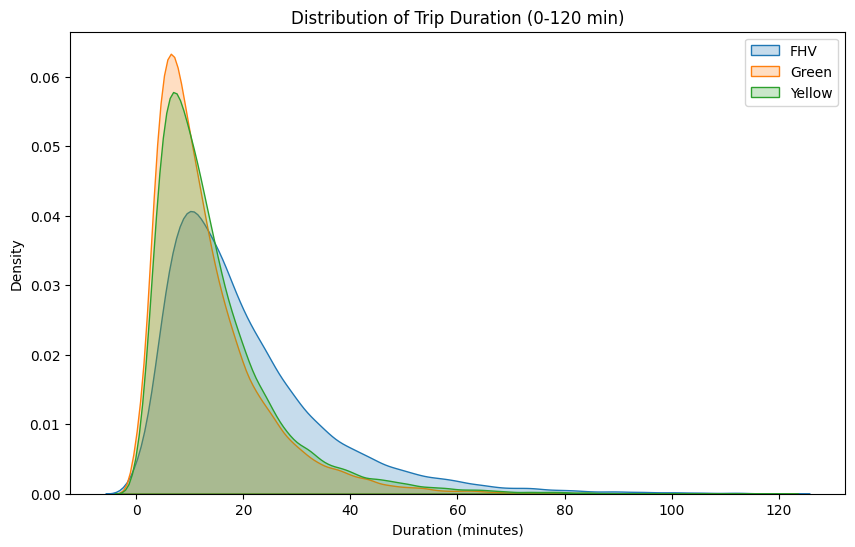

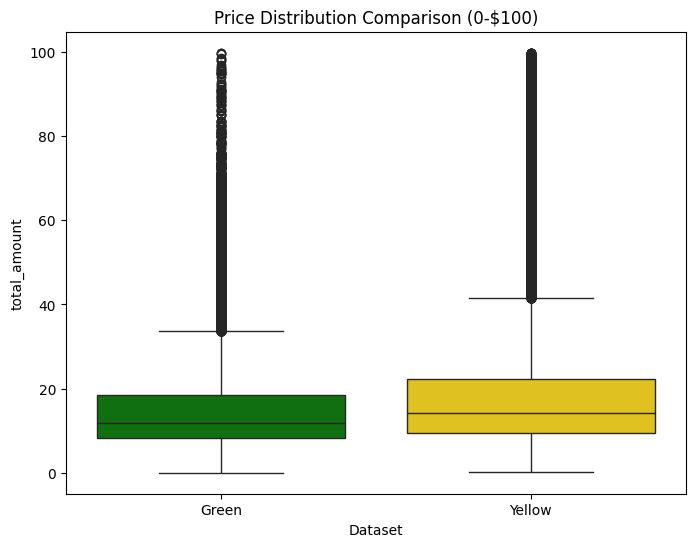

In [26]:
# Filter data for meaningful plots
# Duration within 0 to 120 minutes
fhv_clean_dur = fhv_df[(fhv_df['duration_minutes'] > 0) & (fhv_df['duration_minutes'] <= 120)]
green_clean_dur = green_df[(green_df['duration_minutes'] > 0) & (green_df['duration_minutes'] <= 120)]
yellow_clean_dur = yellow_df[(yellow_df['duration_minutes'] > 0) & (yellow_df['duration_minutes'] <= 120)]

plt.figure(figsize=(10, 6))
sns.kdeplot(fhv_clean_dur['duration_minutes'], label='FHV', fill=True)
sns.kdeplot(green_clean_dur['duration_minutes'], label='Green', fill=True)
sns.kdeplot(yellow_clean_dur['duration_minutes'], label='Yellow', fill=True)
plt.title('Distribution of Trip Duration (0-120 min)')
plt.xlabel('Duration (minutes)')
plt.legend()
plt.savefig('duration_distribution.png')

# Boxplot for Price Comparison
combined_price = pd.concat([
    green_df[['total_amount']].assign(Dataset='Green'),
    yellow_df[['total_amount']].assign(Dataset='Yellow')
])
# Filter for reasonable range
combined_price = combined_price[(combined_price['total_amount'] > 0) & (combined_price['total_amount'] < 100)]

plt.figure(figsize=(8, 6))
sns.boxplot(x='Dataset', y='total_amount', data=combined_price, palette=['green', 'gold'])
plt.title('Price Distribution Comparison (0-$100)')
plt.savefig('price_boxplot.png')

# Outlier Highlight for Green Taxi Distance (Visualizing the anomaly)
extreme_green = green_df[green_df['trip_distance'] > 100]
print(f"Green Taxi trips > 100 miles: {len(extreme_green)}")
print(extreme_green[['trip_distance', 'total_amount', 'duration_minutes']].head())

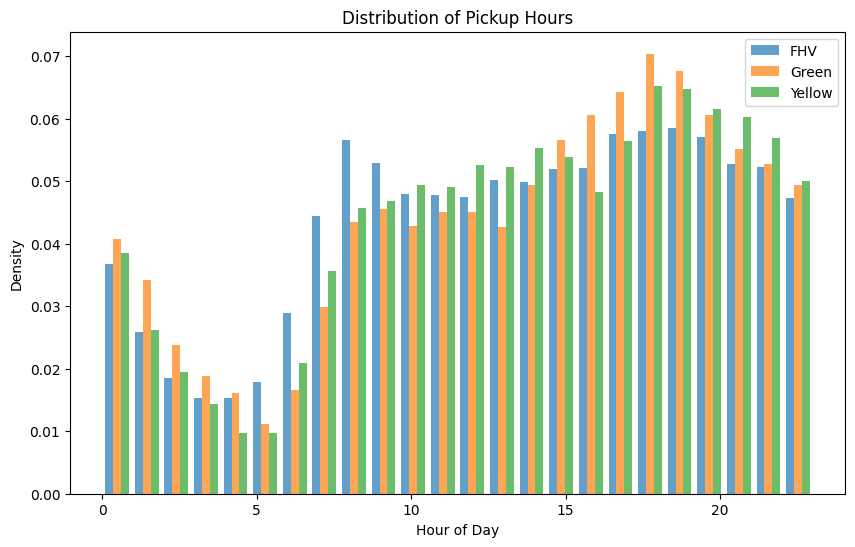

In [16]:
# Hourly distribution
fhv_df['hour'] = fhv_df['pickup_datetime'].dt.hour
green_df['hour'] = green_df['pickup_datetime'].dt.hour
yellow_df['hour'] = yellow_df['pickup_datetime'].dt.hour

plt.figure(figsize=(10, 6))
# Histogram of pickup hours
plt.hist([fhv_df['hour'].dropna(), green_df['hour'].dropna(), yellow_df['hour'].dropna()], 
         bins=24, label=['FHV', 'Green', 'Yellow'], density=True, alpha=0.7)
plt.title('Distribution of Pickup Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Density')
plt.legend()
plt.savefig('hourly_distribution.png')

## Interpretation der Visualisierung ##

Verteilung der Fahrdauer (0–120 Minuten):
Die Verteilungen von Green Taxi und Yellow Taxi zeigen ein sehr ähnliches Muster mit Häufungen im Bereich von etwa 10–15 Minuten. Die FHV-Daten weisen hingegen Auffälligkeiten auf, sodass ein direkter Vergleich ohne vorherige Filterung nur eingeschränkt sinnvoll ist.

Boxplot der Fahrpreise:
Der Boxplot zeigt, dass die Fahrpreise bei Yellow Taxi insgesamt eine größere Spannweite aufweisen und der Median über dem von Green Taxi liegt.

# Ergebnisse des Vergleichs #

## Missing Values Vergleich ##

Disclaimer: Daten aus anderen Notebooks wurden als Basis für den Vergleich genommen. Alle herbeigezogenen Daten können in den jeweiligen Notebooks gefunden oder erneut erstellt werden.

Die systematische Gegenüberstellung der Fehlwerte zeigt erhebliche qualitative Divergenzen zwischen den klassischen Taxi-Datensätzen und dem FHV-Sektor:

1. Kritische Geodaten-Lücken (Location IDs)
Status Quo: Während Yellow und Green Taxi eine Fehlerquote von 0,00 % bei den Standort-IDs aufweisen, zeigt der FHV-Datensatz massive Defizite.
    -> Auffälligkeit: Beim Abholort (PULocationID) fehlen bereits 25,33 %, beim Zielort (DOLocationID) sogar 39,54 % der Daten.
BI-Konsequenz: Eine valide Routen- oder Heatmap-Analyse ist für den FHV-Sektor aufgrund dieser Lücken faktisch nicht möglich.

2. Strukturelle Defizite in den Zusatzgebühren
Congestion Surcharge: Dieses Feld weist bei Yellow (~65,71 %) und Green (~91,07 %) hohe Missing-Rates auf. 
    -> Dies korreliert vermutlich mit den Einsatzgebieten: Da Green Taxis primär außerhalb Manhattans operieren, wird die Staugebühr dort seltener fällig.

Ehail-fee: Dieses Attribut ist im Green Taxi Datensatz zu 100,00 % nicht befüllt. 
    -> Es stellt damit den einzigen "Totalausfall" über alle drei Tabellen hinweg dar und besitzt keinerlei Informationswert für BI-Analysen.

Airport_fee: Nur im Yellow Taxi Datensatz vorhanden, jedoch mit einer Fehlquote von 70,74 % ebenfalls stark lückenhaft.

3. Sektorspezifische Attribute (FHV)
SR_Flag (Shared Rides): Mit einer Missing-Rate von 88,37 % im FHV-Datensatz sind Analysen zum Pooling-Verhalten oder zur Auslastungseffizienz statistisch nicht belastbar.

4. Weitere Auffälligkeiten (Passagierzahlen)
In den Taxi-Datensätzen sind die Passagierzahlen sehr zuverlässig erfasst (Missing-Rate: Yellow 2,20 %, Green 3,28 %). Im FHV-Datensatz fehlt dieses Attribut komplett, was Kapazitätsanalysen erschwert.


## Outliners Vergleich ##

a) Fahrdauer (Duration)

FHV (Kritisch!): Der Datensatz enthält massive Fehler.

Befund: In der Stichprobe haben 34% (17.025 von 50.000) der Fahrten eine negative Dauer. Das bedeutet, der dropOff Zeitstempel liegt vor dem pickup.

Extreme: Die Spanne reicht von -14 Mio. Minuten bis +126.000 Minuten.

Green & Yellow:

Sehr plausible Verteilungen. Der Durchschnitt liegt bei beiden ähnlich (Yellow: ~15 min, Green: ~19 min).

Negative Dauern kommen vor, sind aber vernachlässigbar wenige Einzelfälle (< 10 Fälle).

b) Distanz (Trip Distance)

Green Taxi (Auffällig): Enthält extrem unplausible Ausreißer.

Befund: Es gibt Fahrten mit angeblich > 130.000 Meilen Distanz, die aber nur 17 $ kosten und 1 Stunde dauern. Hier liegen offensichtlich Sensor- oder Erfassungsfehler vor.

Yellow Taxi:

Sehr sauber. Max. Distanz in der Stichprobe liegt bei plausiblen ~85 Meilen.

FHV: Keine Distanz-Daten vorhanden.

c) Preis (Total Amount)

Vergleich: Yellow Taxi Fahrten sind im Schnitt etwas teurer (~19,40 $) als Green Taxi (~15,40 $).

Negativ-Werte: Beide Datensätze enthalten negative Preise (wahrscheinlich Rückerstattungen/Stornos).

Yellow: 182 Fälle

Green: 122 Fälle

### Deepdive Negative Werte ###

Deep Dive: Analyse der Negativwerte & Anomalien (Stichprobe: 50k)
Der Vergleich der Fehlertypen zeigt, dass die Datensätze unterschiedliche technische Schwachstellen haben:

1. Fehlerquoten im Vergleich
Fahrpreis (Fare Amount): Bei Yellow Taxi ist die Fehlerquote mit 0,47 % (237 von 50k) doppelt so hoch wie bei Green Taxi mit 0,24 % (118 von 50k). Negative Preise sind das häufigste Problem in beiden Datensätzen.

Distanz (Trip Distance): Hier punktet Yellow Taxi mit einer Fehlerquote von 0,00 %. Bei Green Taxi sind 23 Fahrten (0,05 %) negativ. Das deutet auf ein robusteres Erfassungssystem für Distanzen bei Yellow hin.

Dauer (Duration): Green Taxi ist hier fehlerfrei (0,00 %), während Yellow Taxi leichte Probleme mit negativen Zeitwerten hat (7 von 50k).

2. Langläufer (> 180 Min.)
Auffälligkeit: Bei Green Taxi ist der Anteil extrem langer Fahrten mit 0,55 % (276 von 50k) massiv höher als bei Yellow (0,07 %).

BI-Interpretation: Da Green Taxis oft in den Außenbezirken (Outer Boroughs) starten, könnten dies echte Langstrecken sein – wahrscheinlicher ist jedoch, dass die Fahrer öfter vergessen, das Taxameter zu beenden.

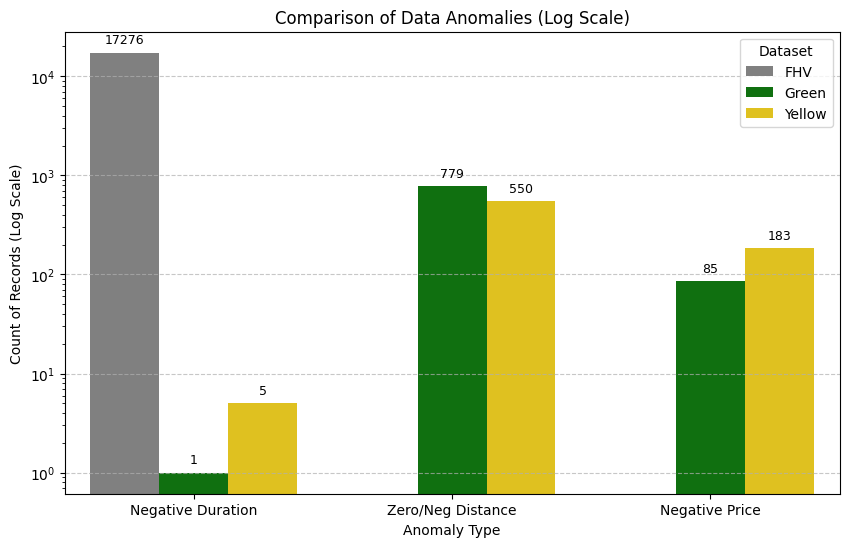

In [27]:
# --- Comparative Bar Chart of Anomalies ---
# Calculate counts
anomalies = []

# Helper function
def get_counts(name, df, dist_col='trip_distance', price_col='total_amount'):
    neg_dur = (df['duration_minutes'] < 0).sum()
    
    if dist_col in df.columns:
        zero_dist = (df[dist_col] <= 0).sum()
    else:
        zero_dist = 0 # Not applicable for FHV
        
    if price_col in df.columns:
        neg_price = (df[price_col] < 0).sum()
    else:
        neg_price = 0 # Not applicable for FHV
        
    return [
        {'Dataset': name, 'Type': 'Negative Duration', 'Count': neg_dur},
        {'Dataset': name, 'Type': 'Zero/Neg Distance', 'Count': zero_dist},
        {'Dataset': name, 'Type': 'Negative Price', 'Count': neg_price}
    ]

anomalies.extend(get_counts('FHV', fhv_df))
anomalies.extend(get_counts('Green', green_df))
anomalies.extend(get_counts('Yellow', yellow_df))

anom_df = pd.DataFrame(anomalies)

plt.figure(figsize=(10, 6))
# We will use log scale on Y axis
bp = sns.barplot(x='Type', y='Count', hue='Dataset', data=anom_df, palette=['grey', 'green', 'gold'])
plt.yscale('log')
plt.title('Comparison of Data Anomalies (Log Scale)')
plt.ylabel('Count of Records (Log Scale)')
plt.xlabel('Anomaly Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels
for p in bp.patches:
    height = p.get_height()
    if height > 0:
        bp.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize=9)
plt.savefig('anomalies_barchart_log.png')

Interpretation: Vergleich der Datenanomalien (Logarithmische Skala)
Das Balkendiagramm zeigt die Häufigkeit verschiedener Fehlerarten über die drei Taxi-Datensätze hinweg. Aufgrund der extremen Unterschiede in der Fehleranzahl musste eine logarithmische Skala verwendet werden (jede Stufe auf der Y-Achse ist eine Verzehnfachung), um die kleineren Balken überhaupt sichtbar zu machen.

Wichtige Erkenntnisse:

FHV (Grauer Balken) – Systemisches Zeitproblem: Der Balken für "Negative Duration" bei FHV ist massiv und überragt alle anderen Anomalien bei Weitem. Mit über 17.000 Fällen (in einer 50k Stichprobe!) sind mehr als 30% der Daten fehlerhaft (Drop-off Zeit liegt vor Pick-up Zeit). Dies deutet auf einen fundamentalen Fehler in der Datenerfassung oder dem Export-Prozess der FHV-Dienstleister hin.

Green Taxi (Grüner Balken) – Sensor-Probleme: Auffällig ist hier der vergleichsweise hohe Balken für "Zero/Neg Distance" (Mitte). Das bedeutet, Green Taxis haben häufiger Probleme, die gefahrene Strecke korrekt zu erfassen (0 Meilen oder negative Werte), selbst wenn die Abrechnung (Preis) korrekt scheint.

Yellow Taxi (Gelber Balken) – Der stabile Standard: Yellow Taxi zeigt zwar auch Anomalien (hauptsächlich "Negative Price" durch Stornierungen), aber diese bewegen sich in einem für Rohdaten üblichen Rahmen (Hunderter-Bereich). Es gibt keine massiven Ausreißer in kritischen Dimensionen wie der Zeitmessung.

Fazit für das Projekt: Die Grafik beweist, warum FHV für Zeitanalysen ohne massive Bereinigung unbrauchbar ist. Yellow Taxi bestätigt seinen Ruf als zuverlässigste Datenquelle, während bei Green Taxi ein spezieller Fokus auf die Bereinigung der Distanz-Spalte gelegt werden muss.

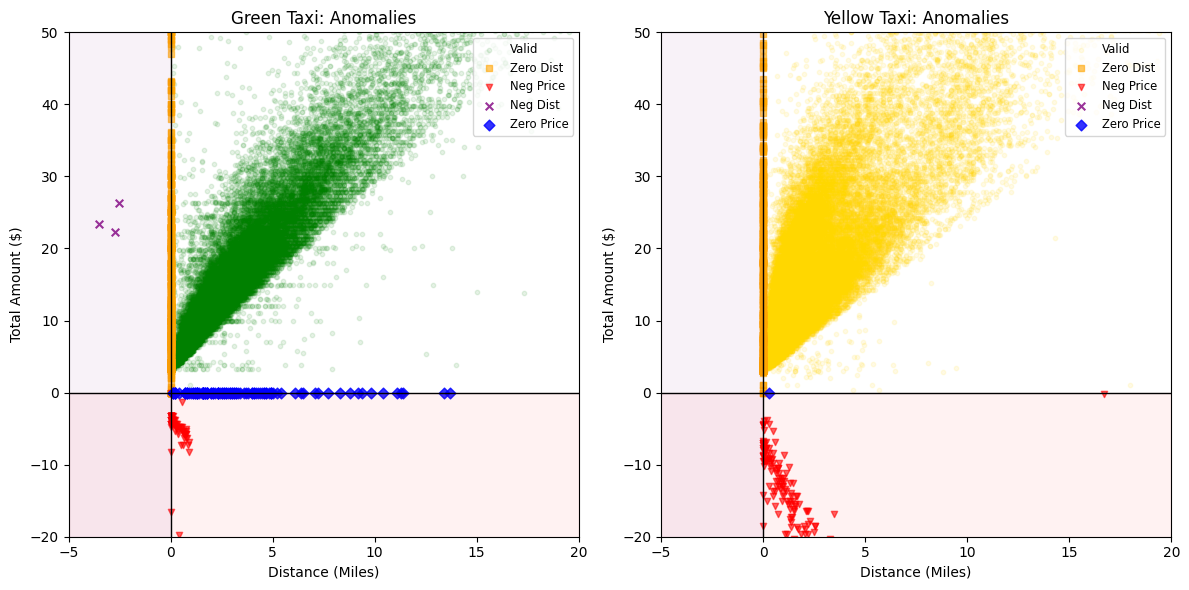

In [29]:
# --- Anomalies Green vs. Yellow ---
plt.figure(figsize=(12, 6))

def plot_anomalies_final(ax, df, title, color_main):
    # Categories
    # 1. Valid: Dist > 0, Price > 0
    valid = df[(df['trip_distance'] > 0) & (df['total_amount'] > 0)]
    
    # 2. Negative Price: Price < 0
    neg_price = df[df['total_amount'] < 0]
    
    # 3. Negative Distance: Dist < 0
    neg_dist = df[df['trip_distance'] < 0]
    
    # 4. Zero Distance: Dist == 0 (and Price >= 0)
    zero_dist = df[(df['trip_distance'] == 0) & (df['total_amount'] >= 0)]
    
    # 5. Zero Price: Dist > 0 and Price == 0
    zero_price = df[(df['trip_distance'] > 0) & (df['total_amount'] == 0)]

    # Plotting
    # Valid - keep faint
    ax.scatter(valid['trip_distance'], valid['total_amount'], c=color_main, alpha=0.1, label='Valid', s=10)
    
    # Anomalies - make distinct
    ax.scatter(zero_dist['trip_distance'], zero_dist['total_amount'], c='orange', alpha=0.6, label='Zero Dist', s=20, marker='s')
    ax.scatter(neg_price['trip_distance'], neg_price['total_amount'], c='red', alpha=0.6, label='Neg Price', s=20, marker='v')
    ax.scatter(neg_dist['trip_distance'], neg_dist['total_amount'], c='purple', alpha=0.8, label='Neg Dist', s=30, marker='x')
    
    # Zero Price (Blue Diamonds)
    ax.scatter(zero_price['trip_distance'], zero_price['total_amount'], c='blue', alpha=0.8, label='Zero Price', s=30, marker='D')

    # Mark the Impossible Zones (subtle background shading)
    ax.axhspan(ymin=-100, ymax=0, xmin=0, xmax=1, color='red', alpha=0.05)
    ax.axvspan(xmin=-100, xmax=0, ymin=0, ymax=1, color='purple', alpha=0.05)
    
    # Standard Axis Lines (Black, subtle)
    ax.axhline(0, color='black', linewidth=1)
    ax.axvline(0, color='black', linewidth=1)
    
    ax.set_title(title)
    ax.set_xlabel('Distance (Miles)')
    ax.set_ylabel('Total Amount ($)')
    
    # Zoom in
    ax.set_xlim(-5, 20)
    ax.set_ylim(-20, 50)
    ax.legend(loc='upper right', fontsize='small')

# Plot Green
ax1 = plt.subplot(1, 2, 1)
plot_anomalies_final(ax1, green_df, 'Green Taxi: Anomalies', 'green')

# Plot Yellow
ax2 = plt.subplot(1, 2, 2)
plot_anomalies_final(ax2, yellow_df, 'Yellow Taxi: Anomalies', 'gold')

plt.tight_layout()
plt.show()

Interpretation: Anomalien & "Impossible Zones"
Der Scatterplot visualisiert die Beziehung zwischen Distanz (X-Achse) und Preis (Y-Achse) und deckt dabei vier kritische Datenfehler auf:

Lila (Negative Distanz): Diese physikalisch unmöglichen Werte treten exklusiv beim Green Taxi auf. Dies deutet auf gravierende Fehler in der Erfassungstechnik oder den Sensoren hin.

Rot (Negativer Preis): Beide Datensätze enthalten Fahrten mit negativen Beträgen (unterhalb der X-Achse). Hierbei handelt es sich höchstwahrscheinlich um Stornierungen, Rückbuchungen oder Abrechnungsfehler (Disputes).

Blau (Zero Price): Die blauen Rauten auf der Nulllinie zeigen Fahrten, die eine Distanz zurückgelegt haben, aber 0 $ kosteten (z. B. "Non-Revenue" Fahrten, technische Fehler oder Mitarbeiterfahrten). Diese verzerren Durchschnittspreise massiv.

Orange (Zero Distance): Die Quadrate an der Y-Achse zeigen Fahrten, die berechnet wurden, obwohl der Zähler 0 Meilen registrierte (sog. "Ghost Rides").

Fazit für das BI-Projekt: Während Yellow Taxi zwar kaufmännische Anomalien (Preis = 0 oder < 0) aufweist, ist die physikalische Datenbasis (Distanz) logisch konsistent. Green Taxi hingegen ist "schmutziger" und erfordert in Task 2 ein deutlich aggressiveres Data Cleaning (Entfernung negativer Distanzen), bevor valide KPIs berechnet werden können.

## Management Summary ##

1. Überblick
Die Analyse der drei Datensätze (Yellow Taxi, Green Taxi und FHV) zeigt eine klare Zweiteilung. Während die klassischen Taxis (Yellow/Green) sehr detaillierte Informationen zu Umsatz und genauen Routen liefern, besteht der FHV-Datensatz (Uber/Lyft) hauptsächlich aus reinen Bewegungsdaten ohne finanzielle Details.
Schlussfolgerung: Ein Dashboard kann nicht alle Anbieter gleich behandeln. Es ist notwendig, Finanz-Auswertungen (nur Taxis) und Auswertungen zum Verkehrsaufkommen (Gesamtmarkt) strikt zu trennen.

2. Bewertung der Datenqualität
Die Datensätze unterscheiden sich hinsichtlich ihrer Informationstiefe und Verlässlichkeit erheblich:

Yellow Taxi (Der Referenzstandard) Dieser Datensatz bietet die höchste Qualität und dient als Basis für präzise Wirtschafts- und Routenanalysen. Die Finanzdaten basieren auf exakten Taxameter-Messungen, und die Geodaten weisen eine sehr hohe Genauigkeit auf (ca. 99 % Zuordnung der Zonen). Der Aufwand für die Datenbereinigung ist vergleichsweise gering.

Green Taxi (Der Standard für Außenbezirke) Die Struktur ähnelt der des Yellow Taxis, jedoch mit einem geografischen Fokus auf die Randgebiete New Yorks („Outer Boroughs“). Finanz- und Geodaten sind vorhanden, weisen aber eine höhere Fehleranfälligkeit auf (z. B. negative Beträge), was einen mittleren Bereinigungsaufwand erfordert.

For-Hire Vehicles (FHV) Der FHV-Datensatz repräsentiert zwar das größte Verkehrsvolumen, unterliegt jedoch starken inhaltlichen Einschränkungen. Es liegen keinerlei Finanzinformationen vor, und bei etwa 40 % der Fahrten fehlt der Zielort. Er eignet sich daher ausschließlich für mengenbasierte Trendanalysen, nicht jedoch für wirtschaftliche Auswertungen.

3. Risiken und Probleme
A. Fehlerhafte Werte (Yellow & Green)
In den Taxi-Daten finden sich unlogische Einträge, wie negative Preise, Distanzen von 0 km oder Fahrten über 4 Stunden.

Folge: Ohne Filterung würden Durchschnittswerte (z. B. Umsatz pro Fahrt) verfälscht.

B. Fehlende Daten (FHV)
Der FHV-Datensatz enthält keine Fahrpreise und bei fast der Hälfte der Fahrten fehlt der Zielort.

Folge: Ein direkter Umsatzvergleich zwischen Taxi und Uber ist technisch nicht möglich. Routen-Analysen sind für FHV statistisch nicht belastbar.

4. Empfehlungen für das Dashboard
Basierend auf der Analyse werden folgende Regeln für die Erstellung des Dashboards festgelegt:

    1. Datenbereinigung (Vorbereitung)

    Einsatz eines Qualitäts-Filters für Taxi-Daten: Fahrten mit negativen Preisen, 0 km Distanz oder unrealistischer Dauer werden für die Analyse ausgeschlossen.

    Bei FHV-Daten werden fehlende Orte als "Unbekannt" markiert, damit die Fahrten zumindest in der Gesamtsumme gezählt werden können.

    2. Aufbau der Berichte

    Bereich "Finanzen & Umsatz": Zeigt nur Yellow und Green Taxis (Umsatz, Trinkgeld, Zuschläge). FHV wird hier ausgeblendet.

    Bereich "Verkehrsaufkommen": Zeigt alle Anbieter (Yellow + Green + FHV), um die zeitliche Auslastung (Fahrten pro Stunde) darzustellen.

    Bereich "Karten & Routen": Konzentriert sich auf Yellow und Green Taxis, da hier Start- und Zielorte verlässlich sind.

5. Fazit
Der FHV-Sektor ist wichtig, um die Menge des Verkehrs in New York zu verstehen, eignet sich aber nicht für wirtschaftliche Detailanalysen. Die Qualität des Dashboards wird sichergestellt, indem die Taxi-Daten vor der Nutzung streng gefiltert und die FHV-Daten nur für Volumen-Trends genutzt werden.

## Ideen für nächste Task ##

Für die weitere Verarbeitung im BI-Projekt (Task 2) ergeben sich folgende Pflichten:

Bereinigung FHV: Wenn FHV genutzt werden soll, müssen zwingend alle Zeilen mit dropOff < pickup entfernt oder getauscht werden. Aufgrund der fehlenden Location-IDs ist zu prüfen, ob man FHV für geografische Analysen komplett ausschließt.

Filterung Green Taxi: Es muss ein Plausibilitäts-Filter für Distanz gesetzt werden (z. B. Trip Distance < 100 Meilen oder Prüfung Distanz / Dauer < 100 mph). Die "Monster-Distanzen" verzerren sonst jeden Mittelwert.

Standardisierung: Yellow ist der "Gold Standard". Green sollte an dessen Qualität angeglichen werden. Negative Preise in beiden Datensätzen sollten für Umsatzanalysen auf 0 gesetzt oder entfernt werden (außer Storno-Analysen sind gewünscht).

## Empfehlungen und Folgen für Dashboard ##

Unsere Analyse zeigt, dass die Rohdaten für ein direktes Reporting ungeeignet sind.

Erforderliche Maßnahmen für Task 2a (DWH Implementation):

Implementierung einer Validierungs-Logik im Canonical Layer, die physikalisch unmögliche Fahrten (Negative Zeit/Distanz) automatisch in eine Fehler-Tabelle ausleitet (besonders kritisch für FHV).

Harmonisierung der Schemata, da FHV keine Finanzdaten liefert (Handling von NULL-Values im Fact-Table).

Aggregation: Vorberechnung von Tages-KPIs, um Performance für das Dashboard sicherzustellen.

Das Dashboard in Task 2b wird somit zwei Sichten bieten: Eine Management-View auf die bereinigten Daten (Layer 4) und eine Technical-View auf die Datenqualität (basierend auf den ausgefilterten Datensätzen).